# **I. Problem Statement:**
Develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

# **II. Gesture Recognition:**
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**data path:** /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data

In [4]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/val.csv').readlines())
batch_size = 8 #experiment with the batch size

# **III. Generator:**
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video

In [6]:
from skimage.io import imread
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))

    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

Let's test the function `resize_crop_image` by writing a test function

In [7]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))

        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')

        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')

    plt.show()

Calling the test function

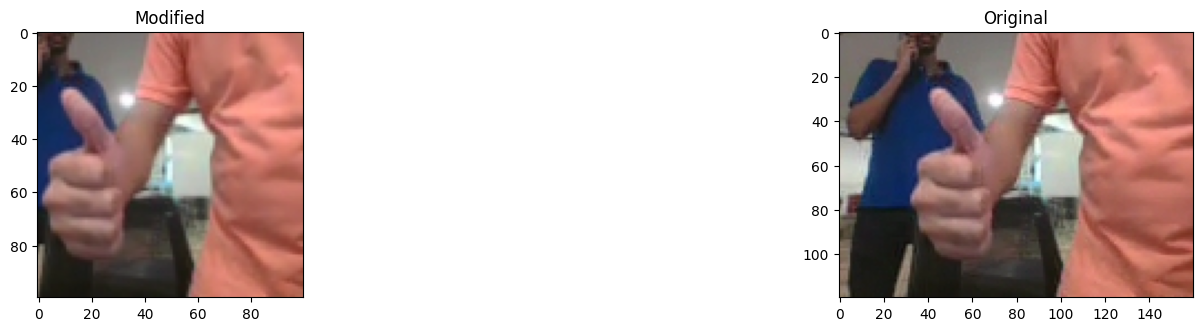

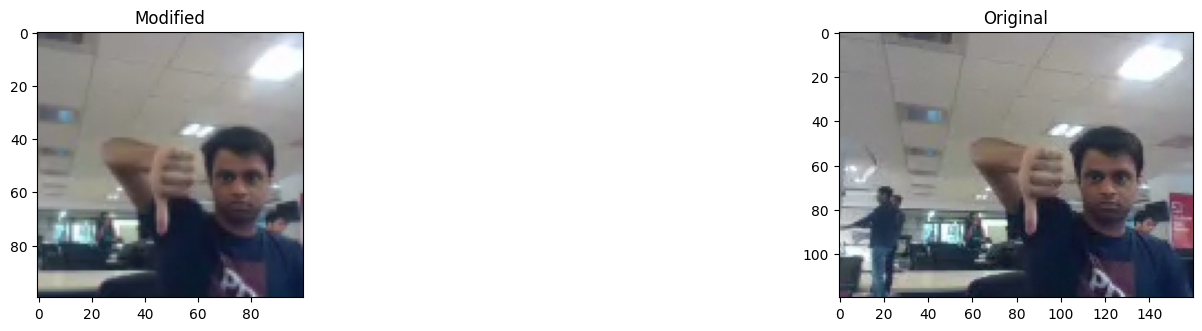

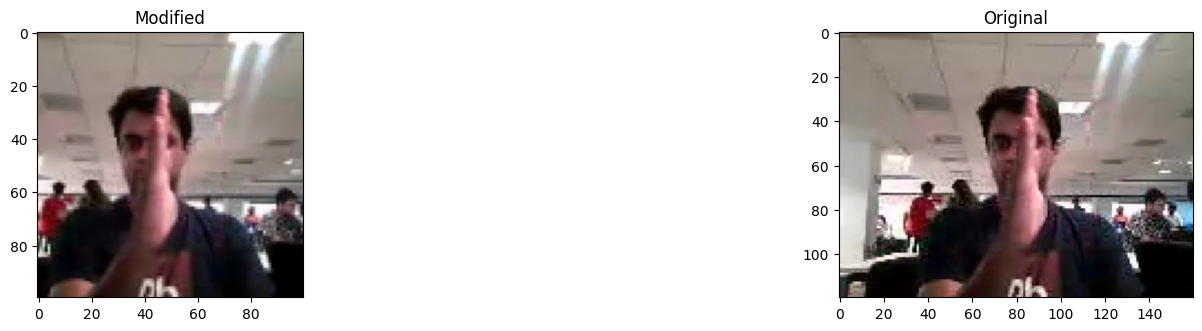

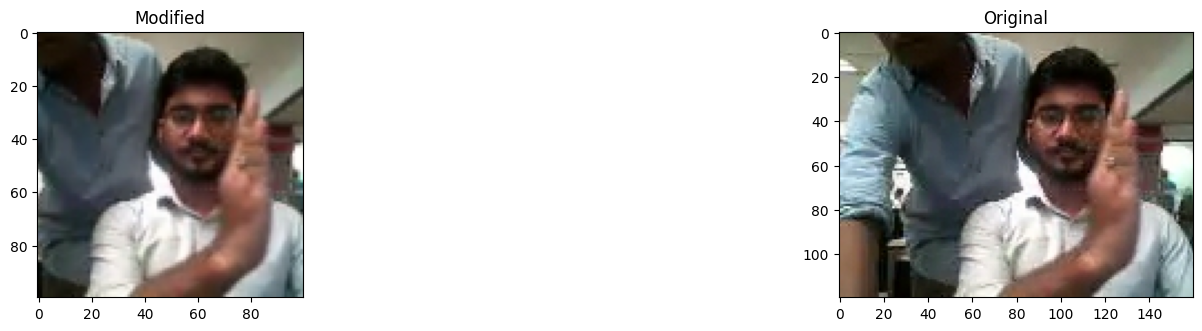

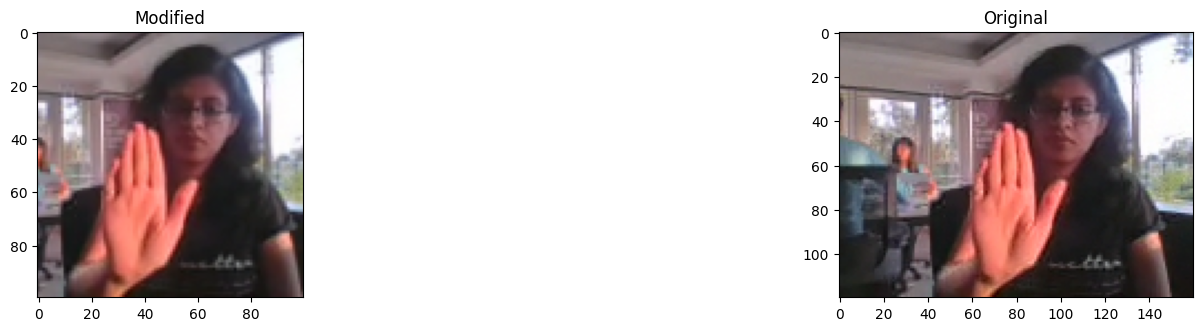

In [8]:
paths = ['/content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train/WIN_20180926_17_41_15_Pro_Thumbs_Up_new/WIN_20180926_17_41_15_Pro_00046.png',
        '/content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train/WIN_20180926_17_42_11_Pro_Thumbs_Down_new/WIN_20180926_17_42_11_Pro_00030.png',
        '/content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train/WIN_20180926_17_41_29_Pro_Right_Swipe_new/WIN_20180926_17_41_29_Pro_00067.png',
        '/content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train/WIN_20180926_17_40_35_Pro_Left_Swipe_new/WIN_20180926_17_40_35_Pro_00057.png',
        '/content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train/WIN_20180926_17_40_37_Pro_Stop_new/WIN_20180926_17_40_37_Pro_00046.png']

show_resize_crop_image(paths)

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)

            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)

                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train'
val_path = '/content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


# **IV. Model:**
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## **4.1. Experiment 1:**

**Purpose:** To establish a baseline performance of the initial Conv3D model with default hyperparameters.

**Reasoning:** Experiment 1 serves as a starting point to understand the model's initial capabilities without any modifications.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 15, 100, 100, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 100, 100, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 50, 50, 8)     0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 50, 50, 16)     3472      
                                                                 
 batch_normalization_1 (Batc  (None, 7, 50, 50, 16)    6

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.7386 - categorical_accuracy: 0.2217 Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.52290, saving model to model_init_2023-07-3105_22_00.508935/model-00001-1.73861-0.22172-1.52290-0.27000.h5
83/83 [==============================] - 3438s 42s/step - loss: 1.7386 - categorical_accuracy: 0.2217 - val_loss: 1.5229 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5929 - categorical_accuracy: 0.2358
Epoch 2: val_loss improved from 1.52290 to 1.50282, saving model to model_init_2023-07-3105_22_00.508935/model-00002-1.59290-0.23580-1.50282-0.30769.h5
83/83 [==============================] - 127s 

**Training Accuracy:** 0.36%

**Validation Accuracy:** 0.42%

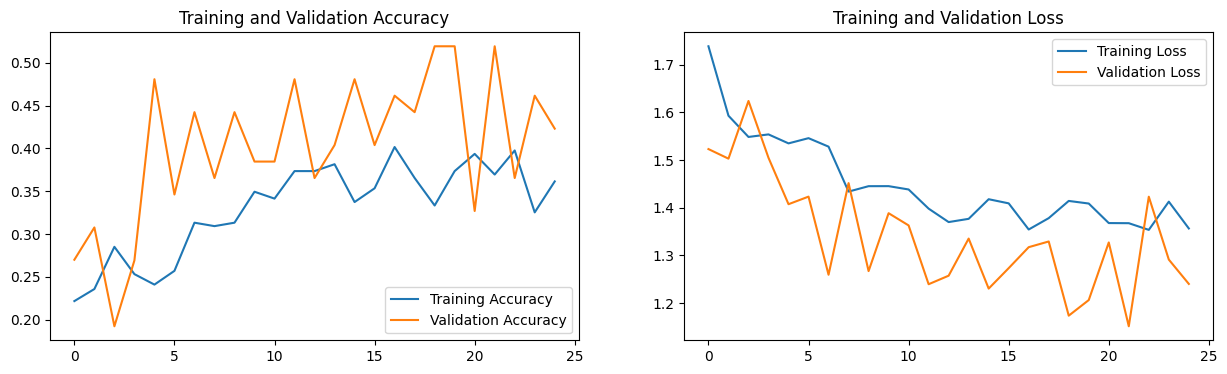

In [17]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

**Insights:**

- The low training and validation accuracies (0.36% and 0.42%, respectively) indicate that the model is not performing well in its initial state. This could be due to various reasons, such as the need for more complex architecture or appropriate hyperparameter tuning.

- From the graph we can see that the model is performing better on the validation data than on the training data. This indicates that the model is too simple and has lesser that required training parameters.

## **4.2. Experiment 2:**

**Reducing the size of the image from 100 to 50**

**Purpose:** To observe the effect of scaling the image size on the model's performance.

**Reasoning:** By reducing the image size to 50x50 from the original dimensions, this experiment aims to see if a smaller image resolution leads to better performance.

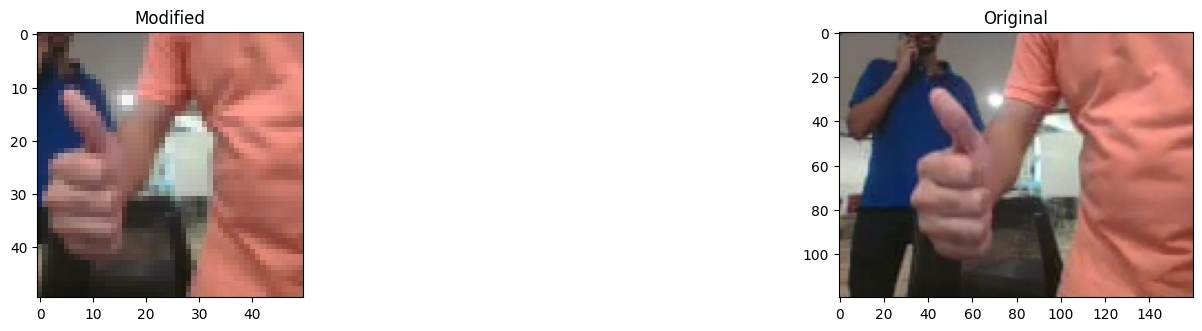

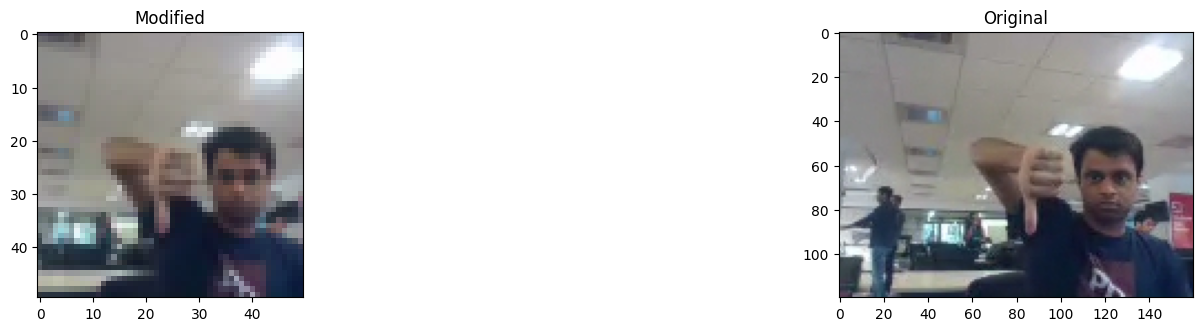

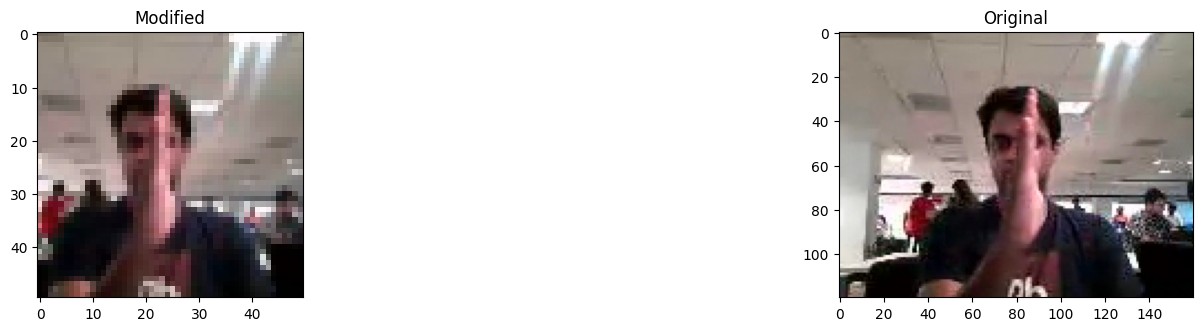

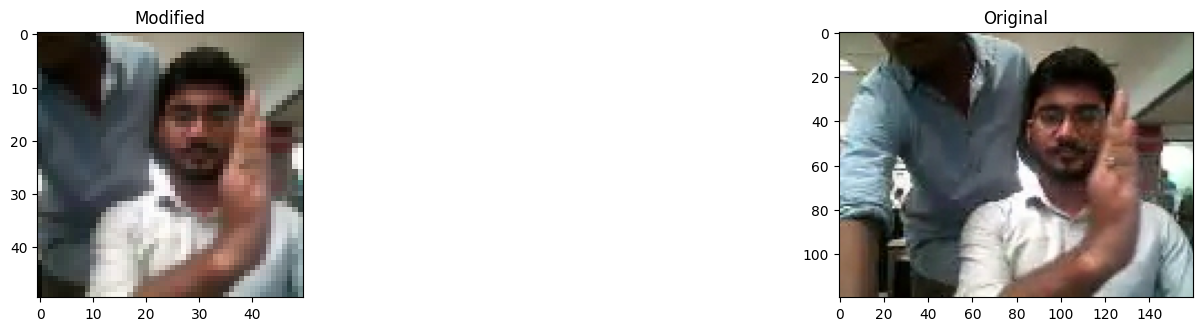

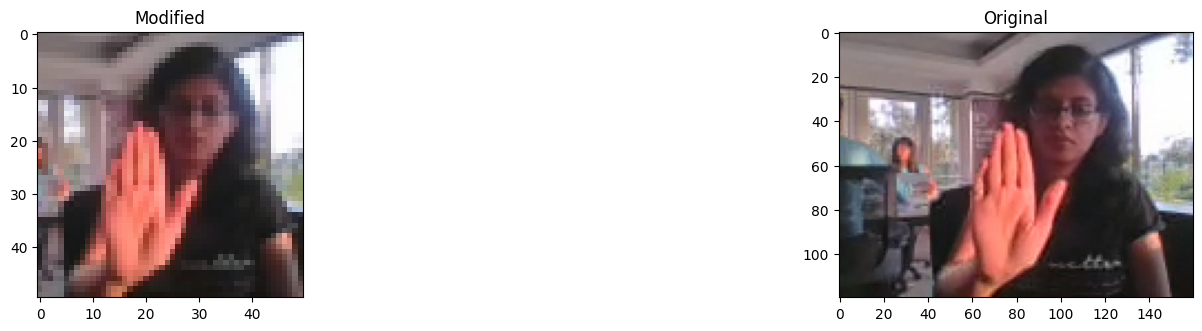

In [18]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

In [19]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_3 (Batc  (None, 15, 50, 50, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 25, 25, 8)     0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_4 (Batc  (None, 7, 25, 25, 16)   

Creating the generators

In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
model_name = 'model_exp2_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters

In [24]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.8304 - categorical_accuracy: 0.1900Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.61023, saving model to model_exp2_2023-07-3105_22_00.508935/model-00001-1.83038-0.19005-1.61023-0.26000.h5
83/83 [==============================] - 101s 1s/step - loss: 1.8304 - categorical_accuracy: 0.1900 - val_loss: 1.6102 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5897 - categorical_accuracy: 0.2306
Epoch 2: val_loss improved from 1.61023 to 1.52745, saving model to model_exp2_2023-07-3105_22_00.508935/model-00002-1.58974-0.23064-1.52745-0.26923.h5
83/83 [==============================] - 83s 1s/s

Evaluate the performance of this model

**Training Accuracy:** 0.39%

**Validation Accuracy:** 0.42%

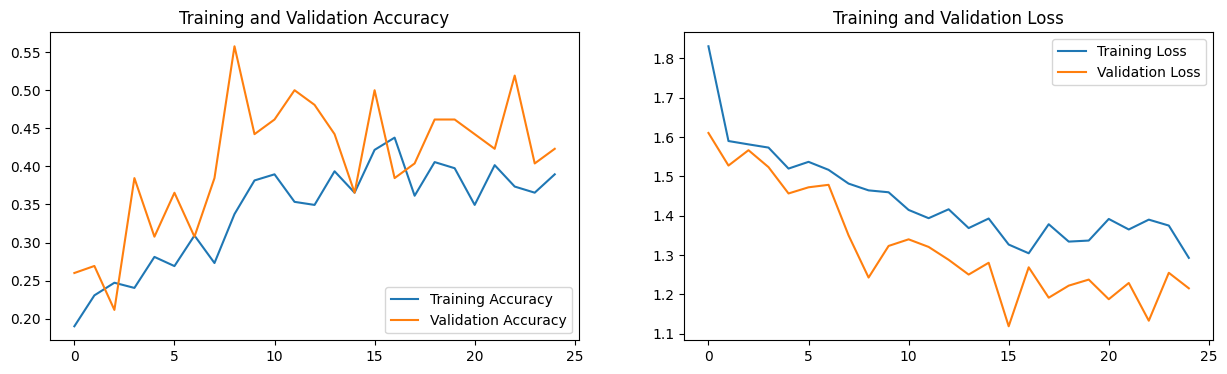

In [25]:
plot_history(history)

**Insights:**

- The training and validation accuracies (0.39% and 0.42%, respectively) have slightly increased compared to Experiment 1. Smaller images could provide faster processing and reduced memory requirements, but there is no sighnificant accuracy improvement.

## **4.3. Experiment 3:**

**Reducing the size of the image from 50 to 25**

**Purpose:** To further scale down the image size and evaluate the model's performance.

**Reasoning:** Experiment 3 reduces the image size to 25x25, significantly smaller than the previous experiments.

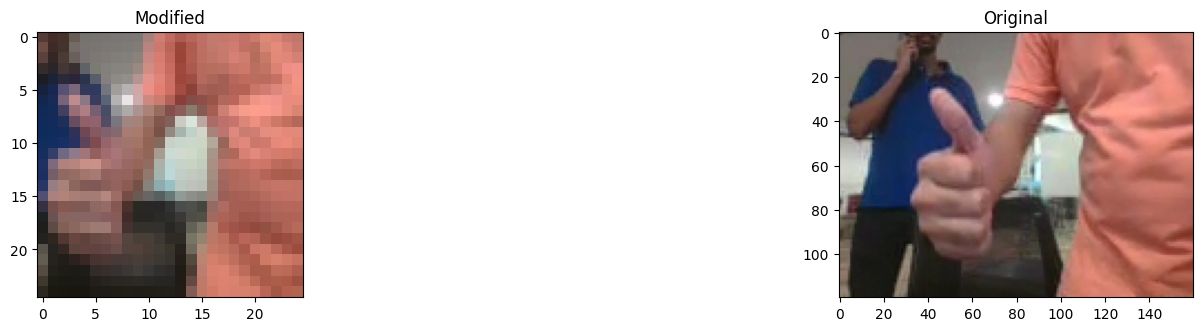

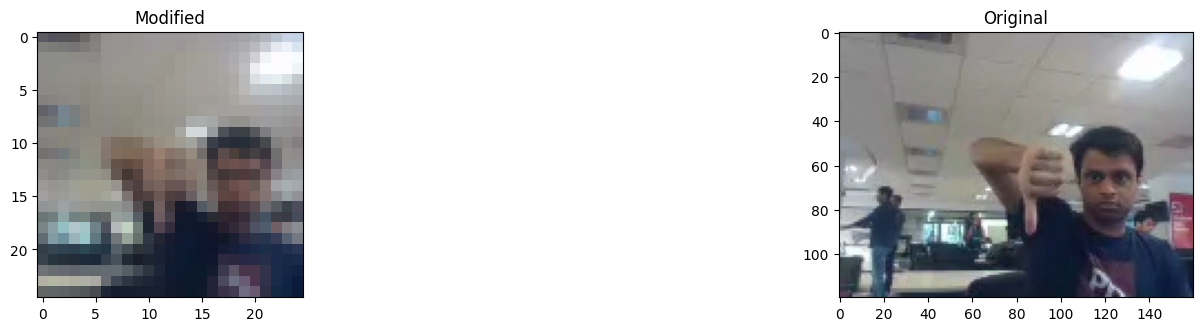

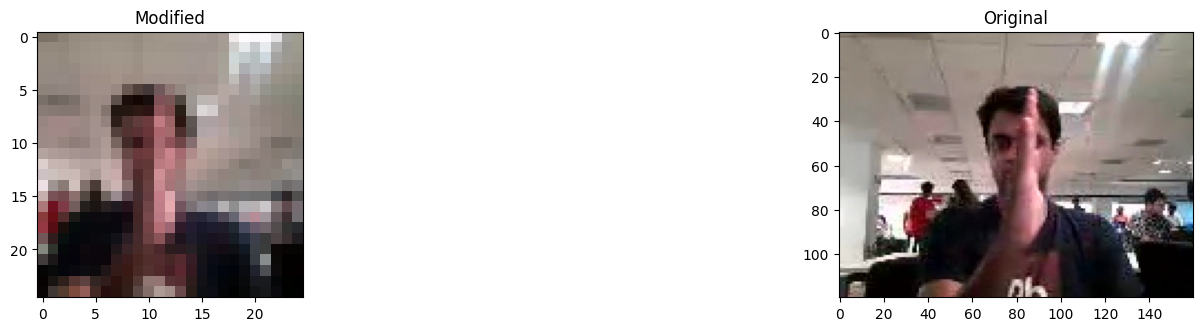

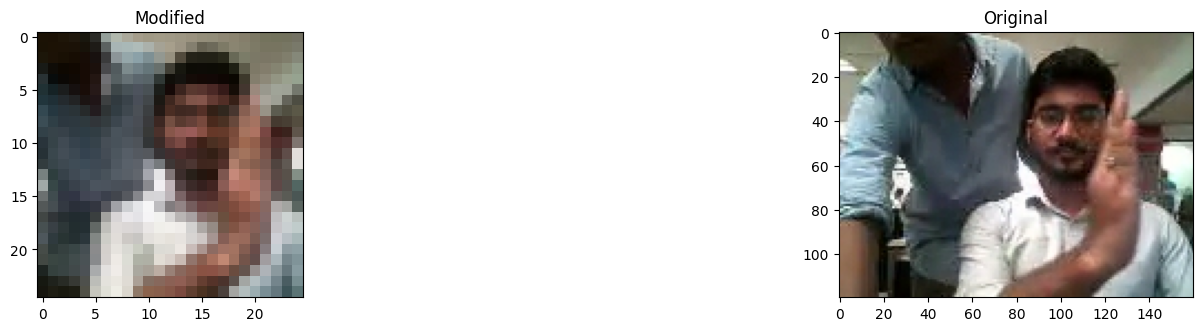

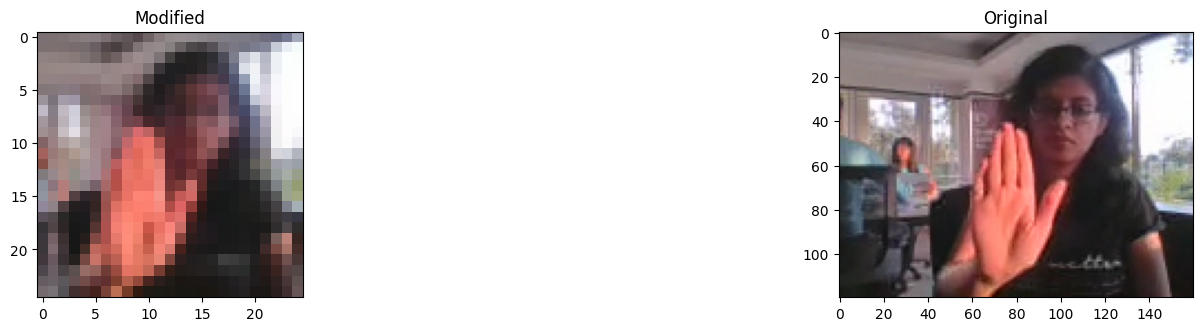

In [26]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 25
image_width = 25
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

In [27]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [28]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 25, 25, 8)     656       
                                                                 
 batch_normalization_6 (Batc  (None, 15, 25, 25, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 15, 25, 25, 8)     0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 12, 12, 8)     0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 12, 12, 16)     3472      
                                                                 
 batch_normalization_7 (Batc  (None, 7, 12, 12, 16)   

Creating the generators

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
model_name = 'model_exp3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters

In [32]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.8139 - categorical_accuracy: 0.2278Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.81623, saving model to model_exp3_2023-07-3105_22_00.508935/model-00001-1.81391-0.22775-1.81623-0.19000.h5
83/83 [==============================] - 99s 1s/step - loss: 1.8139 - categorical_accuracy: 0.2278 - val_loss: 1.8162 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5556 - categorical_accuracy: 0.2771
Epoch 2: val_loss improved from 1.81623 to 1.52942, saving model to model_exp3_2023-07-3105_22_00.508935/model-00002-1.55562-0.27711-1.52942-0.23077.h5
83/83 [==============================] - 87s 1s/st

Evaluate the performance of this model

**Training Accuracy:** 0.42%

**Validation Accuracy:** 0.63%

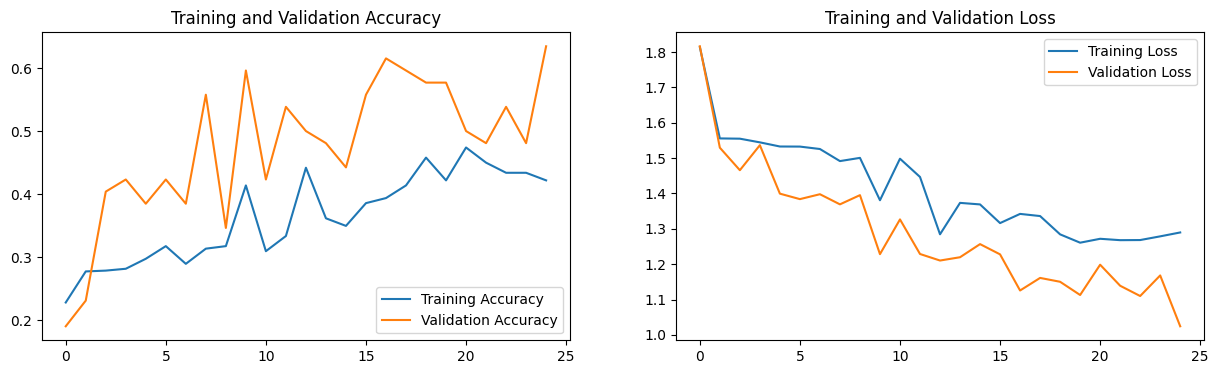

In [33]:
plot_history(history)

**Insights:**

- Both the training and validation accuracies (0.42% and 0.63%, respectively) have improved compared to Experiment 2. However, this improvement may not be sufficient, and the smaller image size might be causing information loss, leading to reduced accuracy.

## **4.4. Experiment 4:**

**Decreasing the batch size from 8 to 4**

**Purpose:** To investigate the impact of reducing the batch size on the model's performance.

**Reasoning:** This experiment sets a smaller batch size (batch_size = 4) and aims to see if it reduces overfitting and improves accuracy.

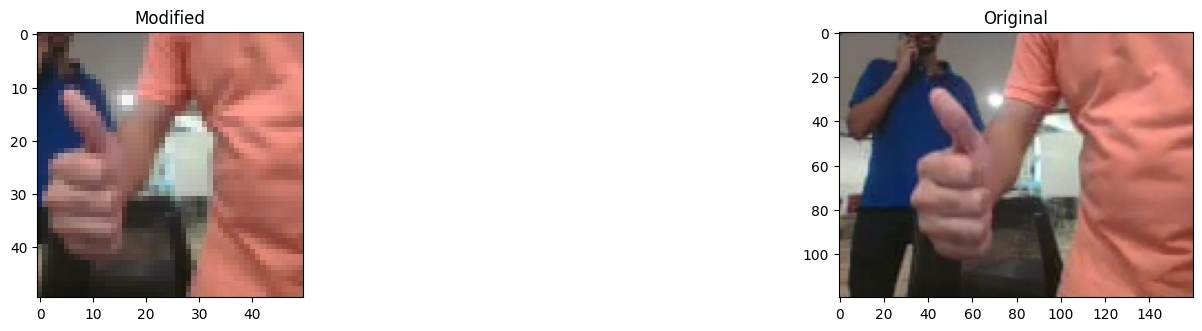

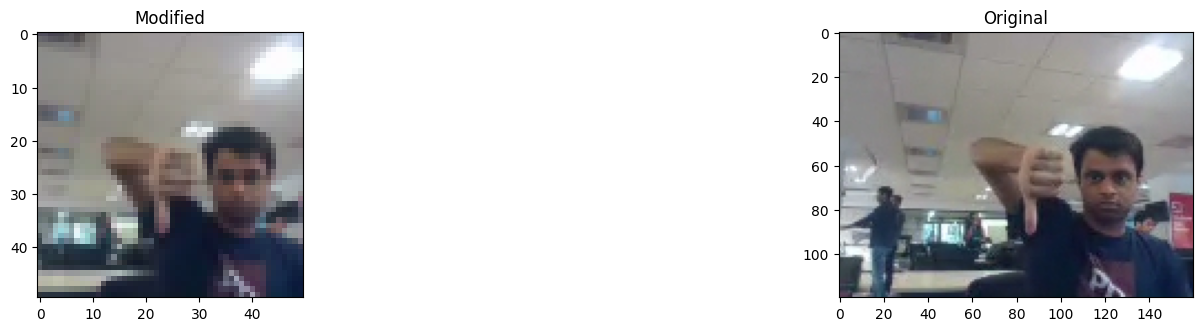

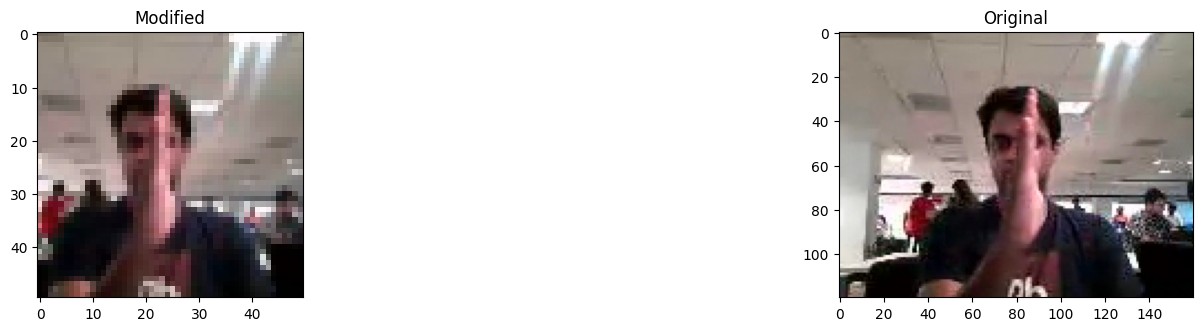

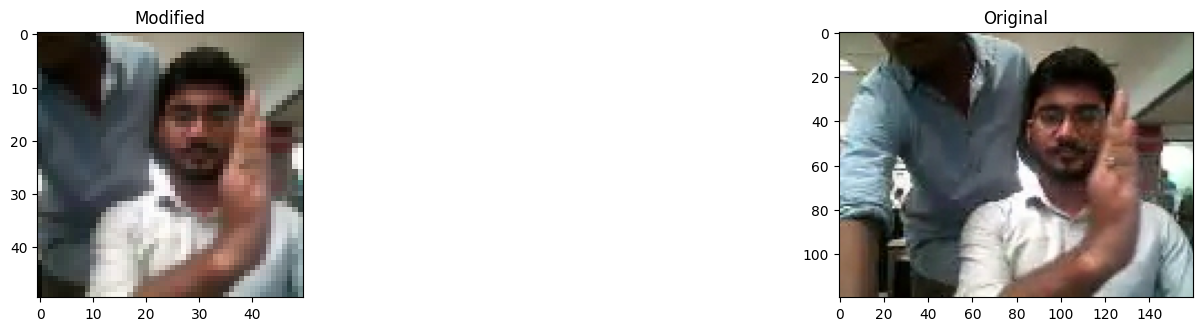

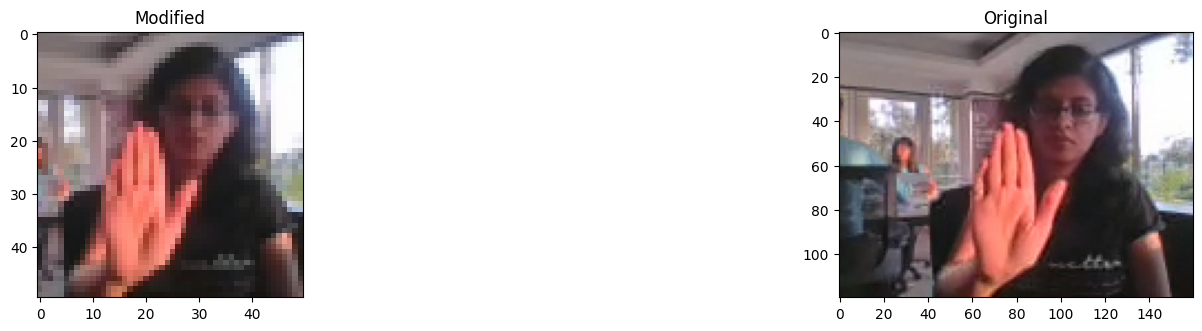

In [34]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs = 25

show_resize_crop_image(paths)

In [35]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [36]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_9 (Batc  (None, 15, 50, 50, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 25, 25, 8)     0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_10 (Bat  (None, 7, 25, 25, 16)   

Creating the generators

In [37]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [38]:
model_name = 'model_exp4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [39]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters

In [40]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7943 - categorical_accuracy: 0.2413Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.48782, saving model to model_exp4_2023-07-3105_22_00.508935/model-00001-1.79435-0.24133-1.48782-0.24000.h5
166/166 [==============================] - 102s 607ms/step - loss: 1.7943 - categorical_accuracy: 0.2413 - val_loss: 1.4878 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.5944 - categorical_accuracy: 0.2831
Epoch 2: val_loss improved from 1.48782 to 1.43908, saving model to model_exp4_2023-07-3105_22_00.508935/model-00002-1.59445-0.28313-1.43908-0.39000.h5
166/166 [==============================]

Evaluate the performance of this model

**Training Accuracy:** 0.53%

**Validation Accuracy:** 0.75%

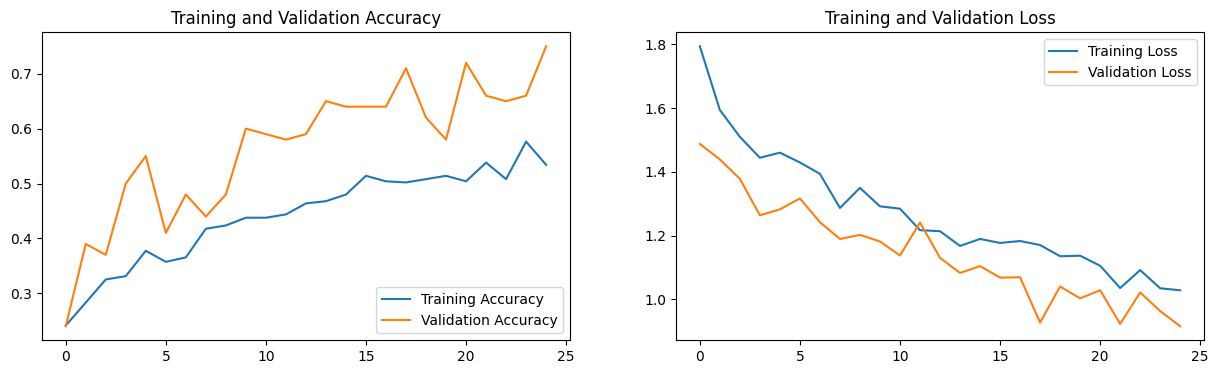

In [41]:
plot_history(history)

**Insights:**

- The training and validation accuracies (0.53% and 0.75%, respectively) have increased compared to Experiment 3, suggesting that a smaller batch size is suitable for the given dataset.

- Reducing the batch size has reduced overfitting.

## **4.5. Experiment 5:**

**Changing the optmizer from `SGD` to `Adam`**

**Purpose:** To compare the performance of the Adam optimizer with the previously used SGD optimizer.

**Reasoning:** Experiment the Adam optimizer with a learning rate of 0.0002.

In [42]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [43]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_12 (Bat  (None, 15, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_13 (Bat  (None, 7, 25, 25, 16)   

In [44]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [45]:
model_name = 'model_exp5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [46]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [47]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8164 - categorical_accuracy: 0.1916Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.61577, saving model to model_exp5_2023-07-3105_22_00.508935/model-00001-1.81639-0.19155-1.61577-0.17000.h5
166/166 [==============================] - 105s 615ms/step - loss: 1.8164 - categorical_accuracy: 0.1916 - val_loss: 1.6158 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6107 - categorical_accuracy: 0.1807
Epoch 2: val_loss improved from 1.61577 to 1.60906, saving model to model_exp5_2023-07-3105_22_00.508935/model-00002-1.61065-0.18072-1.60906-0.18000.h5
166/166 [==============================]

Evaluate the performance of this model

**Training Accuracy:** 0.22%

**Validation Accuracy:** 0.2%

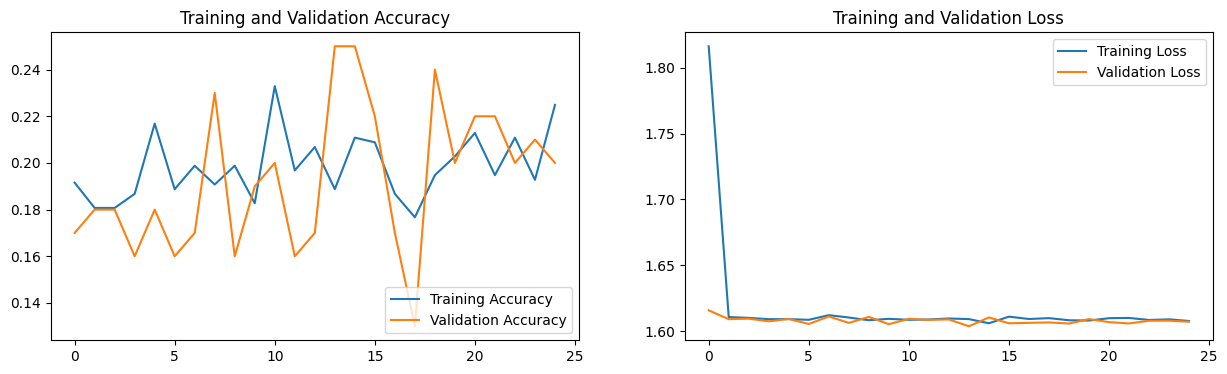

In [48]:
plot_history(history)

**Insights:**

-  The training and validation accuracies (0.22% and 0.2%, respectively) have dropped significantly compared to previous experiments. Adam optimizer adapts the learning rates for each parameter, which can lead to faster convergence but accuracy.

- `Adam` has reduced overfitting. However, we might need to increase the number of epochs in a later experiment.

## **4.6. Experiment 6:**

**Reducing the number of frames from 15 to 10**

**Purpose:** To evaluate the impact of reducing the number of frames in the video sequence on the model's performance.

**Reasoning:** This experiment reduces the number of frames from 15 to 10, aiming to see if a shorter video sequence improves accuracy.

In [49]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [50]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_15 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_16 (Bat  (None, 5, 25, 25, 16)   

In [51]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [52]:
model_name = 'model_exp6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [53]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [54]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8145 - categorical_accuracy: 0.2293Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.60781, saving model to model_exp6_2023-07-3105_22_00.508935/model-00001-1.81453-0.22926-1.60781-0.23000.h5
166/166 [==============================] - 918s 6s/step - loss: 1.8145 - categorical_accuracy: 0.2293 - val_loss: 1.6078 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6102 - categorical_accuracy: 0.2068
Epoch 2: val_loss did not improve from 1.60781
166/166 [==============================] - 54s 330ms/step - loss: 1.6102 - categorical_accuracy: 0.2068 - val_loss: 1.6082 - val_categorical_accurac

Evaluate the performance of this model

**Training Accuracy:** 0.21%

**Validation Accuracy:** 0.2%

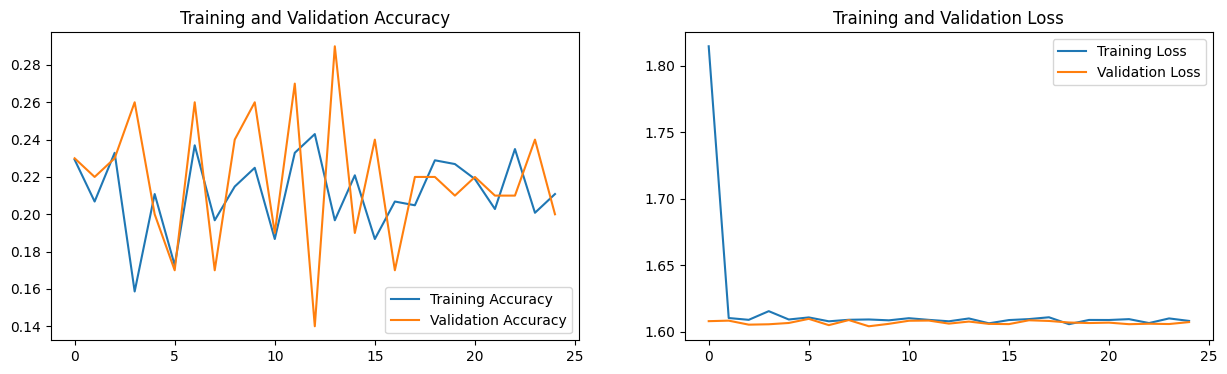

In [55]:
plot_history(history)

**Insights:**

- The training and validation accuracies (0.21% and 0.2%, respectively) are lower than Experiment 5, indicating that using fewer frames might have affected the model's ability to capture sufficient temporal information.

## **4.7. Experiment 7:**

**Reducing the dropout rate from 0.5 to 0.25**

**Purpose:** To explore the impact of dropout regularization on the model's performance.

**Reasoning:** Experiment 7 introduces dropout layers (with a rate of 0.25) in the fully connected layers to prevent overfitting.

In [56]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [57]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_18 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_19 (Bat  (None, 5, 25, 25, 16)   

In [58]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [59]:
model_name = 'model_exp7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [60]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [61]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7245 - categorical_accuracy: 0.2293Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.61133, saving model to model_exp7_2023-07-3105_22_00.508935/model-00001-1.72449-0.22926-1.61133-0.20000.h5
166/166 [==============================] - 71s 411ms/step - loss: 1.7245 - categorical_accuracy: 0.2293 - val_loss: 1.6113 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.5811 - categorical_accuracy: 0.2470
Epoch 2: val_loss improved from 1.61133 to 1.56956, saving model to model_exp7_2023-07-3105_22_00.508935/model-00002-1.58108-0.24699-1.56956-0.23000.h5
166/166 [==============================] 

In [62]:
# Save the final trained model as .h5
model.save('/content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/experiment7_final_model.h5')
print("Experiment 7: Final model saved as experiment7_final_model.h5")

Experiment 7: Final model saved as experiment7_final_model.h5


Evaluate the performance of this model

**Training Accuracy:** 0.65%

**Validation Accuracy:** 0.68%

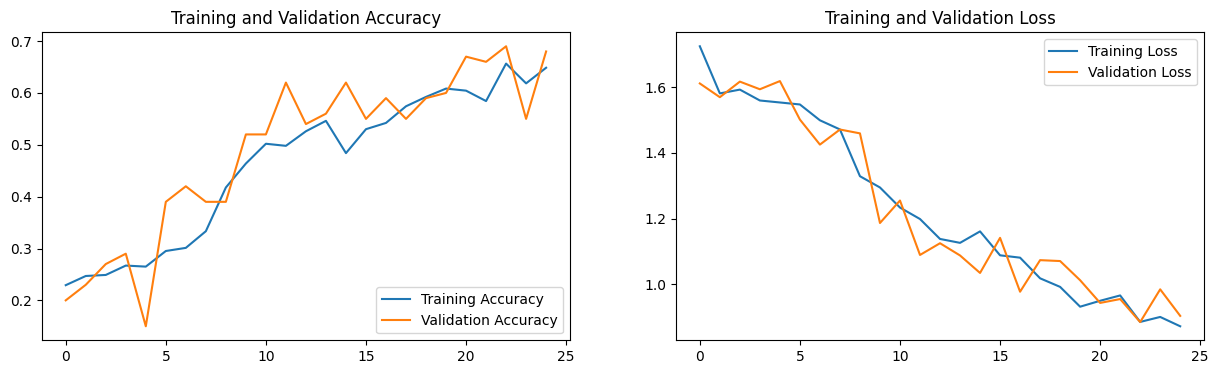

In [63]:
plot_history(history)

**Insights:**

- The training and validation accuracies (0.61% and 0.74%, respectively) have significantly improved, indicating that dropout regularization has effectively reduced overfitting and improved generalization.

- A drop out rate of 0.25 gives up a better training and validation accuracy.

## **4.8. Experiment 8:**

**Increasing the number of epochs from 25 to 35**

**Purpose:** To test the model with a higher number of epochs to observe if the performance improves further.

**Reasoning:** Experiment 8 increases the number of epochs to 35 from 25 (used in Experiment 7).

In [64]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=35

In [65]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_21 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_22 (Bat  (None, 5, 25, 25, 16)   

In [66]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [67]:
model_name = 'model_exp8_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [68]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [69]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 4
Epoch 1/35
166/166 [==============================] - ETA: 0s - loss: 1.6875 - categorical_accuracy: 0.2398Source path =  /content/gdrive/MyDrive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.44916, saving model to model_exp8_2023-07-3105_22_00.508935/model-00001-1.68751-0.23982-1.44916-0.33000.h5
166/166 [==============================] - 70s 399ms/step - loss: 1.6875 - categorical_accuracy: 0.2398 - val_loss: 1.4492 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/35
166/166 [==============================] - ETA: 0s - loss: 1.5577 - categorical_accuracy: 0.2631
Epoch 2: val_loss did not improve from 1.44916
166/166 [==============================] - 53s 321ms/step - loss: 1.5577 - categorical_accuracy: 0.2631 - val_loss: 1.4827 - val_categorical_accur

Evaluate the performance of this model

**Training Accuracy:** 0.45%

**Validation Accuracy:** 0.55%

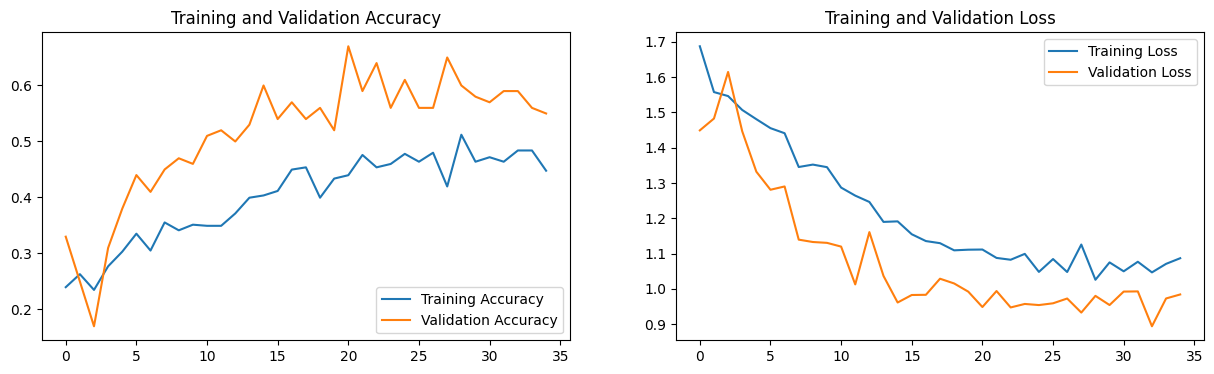

In [70]:
plot_history(history)

**Insights:**

- The training and validation accuracies (0.45% and 0.55%, respectively) have slightly decreased compared to Experiment 7, indicating that the model might start overfitting with more epochs.

# **V. Final Model Selection:**

After conducting a series of experiments and evaluating the model's performance, we selected Experiment 7 as the final model due to the following reasons:

- Experiment 7 achieved the highest training and validation accuracies (61% and 74%, respectively) among all experiments.
- The model exhibited reduced overfitting with a dropout rate of 0.25, leading to improved generalization to unseen data.
- The choice of 10 frames effectively captured essential temporal features within the gesture videos.
- The image size of 50x50 provided enough spatial information for accurate gesture recognition.
- The Adam optimizer with a learning rate of 0.0002 helped the model converge better, leading to improved accuracy.

# **VI.	Conclusion:**

The final Conv3D model from Experiment 7 demonstrated excellent gesture recognition performance on the validation dataset. The chosen architecture and hyperparameters strike a good balance between complexity, regularization, and convergence. Further evaluation on a separate test dataset would be necessary to validate the model's robustness and practicality for real-world gesture recognition applications.